<a href="https://colab.research.google.com/github/fezjo/ml-project/blob/master/ml_project_ciz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://github.com/fezjo/ml-project/raw/master/chat_history.zip
!unzip -o -Pfmfilords chat_history.zip
!pip install unidecode
!pip install gradio

--2023-01-31 15:59:17--  https://github.com/fezjo/ml-project/raw/master/chat_history.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fezjo/ml-project/master/chat_history.zip [following]
--2023-01-31 15:59:18--  https://raw.githubusercontent.com/fezjo/ml-project/master/chat_history.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2804699 (2.7M) [application/zip]
Saving to: ‘chat_history.zip.5’

chat_history.zip.5  100%[===================>]   2.67M  --.-KB/s    in 0.06s   

2023-01-31 15:59:18 (41.6 MB/s) - ‘chat_history.zip.5’ saved [2804699/2804699]

Archive:  chat_history.zip
  inflatin

In [3]:
SHOW_MESSAGES=False

In [4]:
from matplotlib import pyplot as plt

def plot_history(history):
  dpi = 100
  plt.figure(dpi=dpi)
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history.get('val_loss', []), label='validation loss')
  plt.legend(loc='best')

  plt.figure(dpi=dpi)
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history.get('val_accuracy', []), label='validation accuracy')
  plt.legend(loc='best')
  plt.show()

In [5]:
import json

with open("chat_history.json") as chf:
  data = json.load(chf)

In [6]:
from unidecode import unidecode

author_blacklist = {"PollBot", "Dartboi", "Telelog"}
authors = dict()
messages = []
for message in data["messages"]:
  if message["type"] != "message":
    continue
  text_entities, author = message["text_entities"], message["from"]
  if not text_entities or author in author_blacklist:
    continue
  text_chunks = []
  for entity in text_entities:
    text_chunks.append(entity["text"])
  text = "".join(text_chunks)
  text = unidecode(text).lower()
  authors.setdefault(author, len(authors))
  messages.append((text, authors[author]))

if SHOW_MESSAGES:
    print(authors)
    print(messages[:100])

In [7]:
authors = {k.split()[0]: v for k, v in authors.items()}
inv_authors = {v:k for k, v in authors.items()}
authors_names = list(map(lambda a: a[1], sorted(inv_authors.items())))

author_activity = [0] * len(authors)
for message in messages:
  author_activity[message[1]] += 1

for author, activity in zip(authors.items(), author_activity):
  print("{}: {} [{:.2%}]".format(author, activity, activity / len(messages)))

('Jozef', 0): 17808 [27.98%]
('Bohdanator', 1): 6326 [9.94%]
('Daniel', 2): 6078 [9.55%]
('Samuel', 3): 17254 [27.11%]
('Dávid', 4): 15336 [24.10%]
('Pavol', 5): 489 [0.77%]
('Jaroslav', 6): 21 [0.03%]
('Ján', 7): 328 [0.52%]


In [8]:
import numpy as np

ml_stats = []
for len_fun in (lambda m: len(m[0]), lambda m: len(m[0].split())):
    message_lengths = np.array(list(map(len_fun, messages)))
    sml = sorted(message_lengths)
    ml_avg, ml_std = np.mean(message_lengths), np.std(message_lengths)
    print(f"message length / avg: {ml_avg:.2f} / std: {ml_std:.2f}")
    for r in (0.5, 0.68, 0.9, 0.95, 0.99, 0.997, 1):
        i = min(len(sml) - 1, int(len(sml) * r))
        print(r, sml[i])
    print()
    ml_stats.append((ml_avg, ml_std))

message length / avg: 34.47 / std: 60.23
0.5 23
0.68 35
0.9 72
0.95 98
0.99 189
0.997 326
1 4095

message length / avg: 6.31 / std: 8.64
0.5 4
0.68 7
0.9 13
0.95 18
0.99 33
0.997 53
1 610



In [9]:
perm = np.random.permutation(len(messages))
shuffled_messages = [messages[i] for i in perm]
X, Y = map(lambda k: np.array([m[k] for m in shuffled_messages]), (0, 1))
train_test_ratio = 0.8
num_train = int(train_test_ratio * len(X))
X_train, X_test = np.split(X, [num_train])
Y_train, Y_test = np.split(Y, [num_train])
output_shape = len(authors)

if SHOW_MESSAGES:
    print(X[:100])
    print(Y[:100])
print(X.shape, X_train.shape, X_test.shape)
print(Y.shape, Y_train.shape, Y_test.shape)

(63640,) (50912,) (12728,)
(63640,) (50912,) (12728,)


In [10]:
import tensorflow as tf
from tensorflow import keras


# Use the TextVectorization layer to tokenize the input string based on bigrams
sequence_dim_from_stats = lambda stat: int(stat[0] + 2 * stat[1]) * 2
bigram_sequence_dim = sequence_dim_from_stats(ml_stats[0])
preprocessing_char = keras.layers.TextVectorization(
    standardize=None,
    split=tf.strings.bytes_split,
    ngrams=2,
    output_sequence_length=bigram_sequence_dim)
preprocessing_char.adapt(X_train)

word_sequence_dim = sequence_dim_from_stats(ml_stats[1])
preprocessing_word = keras.layers.TextVectorization(
    ngrams=2,
    output_sequence_length=word_sequence_dim,
    max_tokens=10000)
preprocessing_word.adapt(X_train)

# Input layer for string data
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

channels = []
for preprocessing in (preprocessing_char, preprocessing_word):
    # Preprocessing layer
    layer = preprocessing(inputs)

    # Embedding layer
    max_vocab_size = len(preprocessing.get_vocabulary()) + 1
    print(f"Vocabulary size: {max_vocab_size}")
    embedding_dim = 300
    layer = keras.layers.Embedding(
        input_dim=max_vocab_size,
        output_dim=embedding_dim,
    #     embeddings_regularizer="l1",
    )(layer)

    # Add a dropout layer to prevent overfitting
    layer = keras.layers.Dropout(rate=0.25)(layer)

    # Add dimension for channel needed by convolution
    layer = keras.layers.Reshape(target_shape=(*layer.shape[-2:], 1))(layer)

    # # Create 3 parallel branches for convolution with varying window widths
    n_conv_filters = 500 # TODO
    parent_layer = layer
    child_layers = []
    for ks in (3, 4, 5):
        layer = parent_layer

        layer = keras.layers.Conv2D(
            filters=n_conv_filters,
            kernel_size=(ks, embedding_dim),
            activation="selu")(layer)

        # Max pooling layer
        layer = keras.layers.GlobalMaxPooling2D()(layer)
        child_layers.append(layer)

    # Concatenate the outputs of the parallel Conv1D layers
    layer = keras.layers.Concatenate()(child_layers)
    
    channels.append(layer)


# Concatenate the outputs of the char and word channels
layer = keras.layers.Concatenate()(channels)

# # Add a dropout layer to prevent overfitting
layer = keras.layers.Dropout(rate=0.6)(layer)

# # Add a dense layer
# layer = keras.layers.Dense(units=300, activation="relu")(layer)

# Output layer
outputs = keras.layers.Dense(units=output_shape, activation="softmax")(layer)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(0.0002),
    loss="categorical_crossentropy",
    metrics=["accuracy"])
model.summary()

2023-01-31 15:59:52.548270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 15:59:52.646426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 15:59:52.647358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 15:59:52.649727: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Vocabulary size: 3532
Vocabulary size: 10001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 308)          0           input_1[0][0]                    
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 46)           0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 308, 300)     1059600     text_vectorization[0][0]         
_________________________________________________

In [11]:
for preprocessing in (preprocessing_char, preprocessing_word):
    print(preprocessing.get_vocabulary()[:100])

['', '[UNK]', ' ', 'a', 'e', 'o', 't', 'i', 'n', 's', 'm', 'l', 'r', 'd', 'k', 'e  ', 'p', 'u', 'v', 'c', 'z', 'o  ', 'a  ', '  t', 'j', '  s', 'y', 'b', 'h', '  n', 't o', 'n e', '  p', 'm  ', '  a', 'i  ', 'a k', '  m', 'a l', 'n a', 't a', 'i e', '  z', 's t', 't e', 'p r', '  v', 's i', 'y  ', ',', 'l e', 'n i', ',  ', 'o m', 'p o', 'r a', 'm a', 'j e', '?', 'r e', 'a t', 'k o', 'e d', 't  ', 'f', '  d', '  j', 'o v', 'u  ', '  c', 'z e', 'e n', 'l  ', '  b', 'a m', 'a s', 'e s', 's a', 'r o', 'c h', 'i n', 'e m', 'd a', 'd e', 's  ', 'a n', 'k  ', 'c i', '  k', 'l a', 'v e', 'v i', 's o', 'e r', 't i', '.', 'n o', 'i s', 'v a', 'd o']
['', '[UNK]', 'to', 'a', 'je', 'ze', 'som', 'sa', 'na', 'si', 'ale', 'tak', 'v', 'nie', 'co', 'ja', 'ako', 'uz', 'by', 'asi', 'aj', 'tam', 'd', 'ked', 'mi', 'je to', 'ma', 'ten', 'z', 'no', 'o', 'mam', 'alebo', 'este', 'do', 's', 'su', 'ci', 'bude', 'tie', 'lebo', 'ano', 'ak', 'proste', 'to je', 'nieco', 'ti', 'fakin', 'tu', 'mozno', 'mas', 'len', 'z

In [12]:
sample_text = "ak si nic nedas, tak PON UTO PIA mas???!? cely den na pracu a este streda pooobede :D 👍 @david"

inp = model.input                                           # input placeholder
model_outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = lambda outputs: keras.backend.function(inp, outputs)   # evaluation function

# Testing
for output in model_outputs[:3]:
  print(functor([output])(np.array([sample_text])))

[array([[b'ak si nic nedas, tak PON UTO PIA mas???!? cely den na pracu a este streda pooobede :D \xf0\x9f\x91\x8d @david']],
      dtype=object)]
[array([[   3,   14,    2,    9,    7,    2,    8,    7,   19,    2,    8,
           4,   13,    3,    9,   49,    2,    6,    3,   14,    2,    1,
           1,    1,    2,    1,    1,    1,    2,    1,    1,    1,    2,
          10,    3,    9,   58,   58,   58,  275,   58,    2,   19,    4,
          11,   26,    2,   13,    4,    8,    2,    8,    3,    2,   16,
          12,    3,   19,   17,    2,    3,    2,    4,    9,    6,    4,
           2,    9,    6,   12,    4,   13,    3,    2,   16,    5,    5,
           5,   27,    4,   13,    4,    2,  161,    1,    2,    1,    1,
           1,    1,    2,  276,   13,    3,   18,    7,   13,   36,   86,
          25,   47,   35,   29,   51,  154,  218,   29,   31,   62,   82,
          75,  457,   52,   23,   40,   36,   86,    1,    1,    1,    1,
           1,    1,    1,    1,    1,  

Epoch 1/6


2023-01-31 16:00:06.386018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


90/90 [==============================] - 52s 467ms/step - loss: 1.5980 - accuracy: 0.3238 - val_loss: 1.5191 - val_accuracy: 0.3725
Epoch 2/6
90/90 [==============================] - 41s 451ms/step - loss: 1.4900 - accuracy: 0.3935 - val_loss: 1.4699 - val_accuracy: 0.4183
Epoch 3/6
90/90 [==============================] - 41s 451ms/step - loss: 1.4198 - accuracy: 0.4349 - val_loss: 1.4288 - val_accuracy: 0.4338
Epoch 4/6
90/90 [==============================] - 41s 452ms/step - loss: 1.3272 - accuracy: 0.4880 - val_loss: 1.4057 - val_accuracy: 0.4429
Epoch 5/6
90/90 [==============================] - 41s 451ms/step - loss: 1.2377 - accuracy: 0.5303 - val_loss: 1.4057 - val_accuracy: 0.4476
Epoch 6/6
90/90 [==============================] - 41s 452ms/step - loss: 1.1576 - accuracy: 0.5640 - val_loss: 1.4216 - val_accuracy: 0.4450


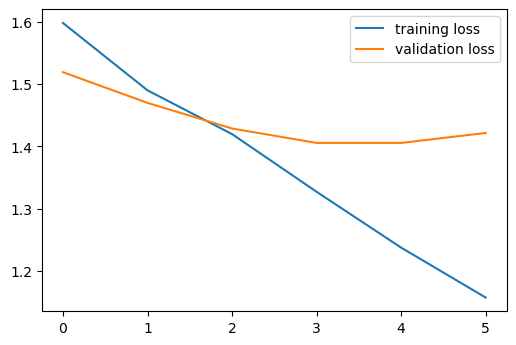

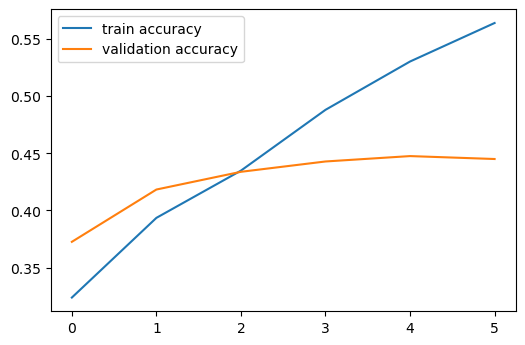

In [13]:
history = model.fit(**{
    "x": X_train,
    "y": keras.utils.to_categorical(Y_train),
    "epochs": 6,
    "batch_size": 512,
    "validation_split": 0.10,
    "verbose": 1,
    })

plot_history(history)

In [14]:
model.save('ml-project-ciz-author_identification.km')

2023-01-31 16:04:20.434252: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [15]:
print(authors)
sample_num = 100
prediction = model.predict(X_test[:sample_num])
for pred, x, y in zip(prediction, X_test, Y_test):
    py = pred.argmax()
    author = inv_authors[y]
    conf = list(map(lambda x: round(x*100), pred))
    msg = f"\n{author}: {x}" if SHOW_MESSAGES else f"{author}"
    print(f"correct={y==py} real={y} pred={py} {conf} {msg}")

{'Jozef': 0, 'Bohdanator': 1, 'Daniel': 2, 'Samuel': 3, 'Dávid': 4, 'Pavol': 5, 'Jaroslav': 6, 'Ján': 7}
correct=True real=3 pred=3 [5, 8, 4, 81, 2, 0, 0, 0] Samuel
correct=False real=4 pred=0 [52, 3, 16, 10, 18, 1, 0, 1] Dávid
correct=False real=1 pred=4 [27, 10, 4, 18, 40, 0, 0, 0] Bohdanator
correct=True real=3 pred=3 [26, 3, 12, 50, 7, 1, 0, 1] Samuel
correct=False real=1 pred=4 [2, 5, 4, 35, 52, 1, 0, 0] Bohdanator
correct=False real=0 pred=3 [44, 2, 3, 48, 3, 0, 0, 0] Jozef
correct=True real=0 pred=0 [40, 20, 5, 7, 26, 1, 0, 1] Jozef
correct=False real=4 pred=0 [69, 8, 6, 10, 5, 1, 0, 1] Dávid
correct=True real=4 pred=4 [0, 14, 11, 21, 52, 1, 0, 0] Dávid
correct=False real=0 pred=3 [17, 7, 18, 44, 12, 1, 0, 1] Jozef
correct=True real=3 pred=3 [37, 8, 4, 43, 6, 1, 0, 1] Samuel
correct=False real=0 pred=3 [17, 2, 5, 72, 4, 0, 0, 0] Jozef
correct=False real=3 pred=0 [46, 4, 7, 32, 10, 0, 0, 0] Samuel
correct=False real=4 pred=3 [6, 6, 5, 50, 32, 1, 0, 0] Dávid
correct=False real=0 p

In [16]:
train_score = model.evaluate(X_train, tf.keras.utils.to_categorical(Y_train))
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(X_test, tf.keras.utils.to_categorical(Y_test))
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

1591/1591 [==============================] - 21s 13ms/step - loss: 1.0976 - accuracy: 0.5926


train loss: 1.0976309776306152 | train acc: 0.5926304459571838

398/398 [==============================] - 5s 13ms/step - loss: 1.4002 - accuracy: 0.4558


test loss: 1.400213360786438 | test acc: 0.4558453857898712


```
Epoch 1/10
716/716 [==============================] - 27s 36ms/step - loss: 1.4964 - accuracy: 0.3837 - val_loss: 1.4383 - val_accuracy: 0.4183
Epoch 2/10
716/716 [==============================] - 25s 36ms/step - loss: 1.4131 - accuracy: 0.4310 - val_loss: 1.3970 - val_accuracy: 0.4354
Epoch 3/10
716/716 [==============================] - 25s 36ms/step - loss: 1.3427 - accuracy: 0.4655 - val_loss: 1.3826 - val_accuracy: 0.4470
Epoch 4/10
716/716 [==============================] - 25s 36ms/step - loss: 1.2733 - accuracy: 0.4990 - val_loss: 1.3885 - val_accuracy: 0.4440
Epoch 5/10
716/716 [==============================] - 25s 35ms/step - loss: 1.1959 - accuracy: 0.5339 - val_loss: 1.3993 - val_accuracy: 0.4521
Epoch 6/10
716/716 [==============================] - 25s 35ms/step - loss: 1.1183 - accuracy: 0.5708 - val_loss: 1.4258 - val_accuracy: 0.4544
Epoch 7/10
716/716 [==============================] - 25s 35ms/step - loss: 1.0404 - accuracy: 0.5998 - val_loss: 1.4407 - val_accuracy: 0.4487
Epoch 8/10
716/716 [==============================] - 25s 35ms/step - loss: 0.9775 - accuracy: 0.6283 - val_loss: 1.4890 - val_accuracy: 0.4476
Epoch 9/10
716/716 [==============================] - 25s 35ms/step - loss: 0.9131 - accuracy: 0.6558 - val_loss: 1.5166 - val_accuracy: 0.4470
Epoch 10/10
716/716 [==============================] - 25s 35ms/step - loss: 0.8509 - accuracy: 0.6859 - val_loss: 1.5764 - val_accuracy: 0.4550
```

In [17]:
import gradio as gr

print(authors_names)
def predict_author(text):
    text = unidecode(text).lower()
    pred = model.predict(np.array([text]))[0]
    pred_y = pred.argmax()
    confidence = list(map(lambda x: round(x*100), pred))
    author = authors_names[pred_y]
    
    plt.axes()
    plt.figure(dpi=200)
    plt.xticks(rotation=45)
    plt.bar(authors_names, confidence)
    fig = plt.gcf()
    return author, fig, f"predicted_author {author} / pred_i={pred_y}\nconfidence={confidence}"

iface = gr.Interface(
    fn=predict_author, 
    inputs='text',
    outputs=[
        gr.Textbox(label="Predicted author"),
        gr.Plot(label="Confidence"),
        gr.Textbox(label="Info")],
    examples=[
      ["tak zalezi aj ze co je to za konverzaciu a ako velmi odlisni su ti ludia"],
      ["jaaaaaj v buse sme sa bavili uz si pamatam"],
      ["no tak taketo nieco by som ja povedal"]
    ],
    live=True,
)

iface.launch(debug=True, share=True)

['Jozef', 'Bohdanator', 'Daniel', 'Samuel', 'Dávid', 'Pavol', 'Jaroslav', 'Ján']
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://31edec69-c8fa-4707.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://31edec69-c8fa-4707.gradio.live


In [19]:
!zip -r ml-project-ciz-author_identification.zip /kaggle/working/ml-project-ciz-author_identification.km

updating: kaggle/working/ml-project-ciz-author_identification.km/ (stored 0%)
  adding: kaggle/working/ml-project-ciz-author_identification.km/variables/ (stored 0%)
  adding: kaggle/working/ml-project-ciz-author_identification.km/variables/variables.index (deflated 69%)
  adding: kaggle/working/ml-project-ciz-author_identification.km/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/ml-project-ciz-author_identification.km/keras_metadata.pb (deflated 93%)
  adding: kaggle/working/ml-project-ciz-author_identification.km/saved_model.pb (deflated 82%)
  adding: kaggle/working/ml-project-ciz-author_identification.km/assets/ (stored 0%)
